In [1]:
import numpy as np
import pandas as pd
import glob
import yaml
from pathlib import Path
from collections import defaultdict

from tqdm.notebook import tqdm

In [2]:
!pip install -q unidecode


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from unidecode import unidecode

city = "České . Budějovice"
print(unidecode(city))

Ceske . Budejovice


In [4]:
def find_heroes_filepaths_by_name(path_list, hero_name):
    new_list = []
    for p in path_list:
        if hero_name.lower() in p.lower():
            new_list.append(p)

    return new_list

def yaml_read(path):
    return yaml.safe_load(Path(path).read_text().strip().replace("\t","\n"))

def create_special_skill_type_list(path_list, return_count=False):
    type_list = []
    n_costume = 0
    n_costume2 = 0
    n_costume3 = 0

    for p in tqdm(path_list):
        d = yaml_read(p)

        if 'types' in d.keys():
            for t in d['types']:
                if not t in type_list:
                    type_list.append(t)
        
        if 'costume' in d.keys():
            n_costume += 1
            d2 = d['costume']
            for t in d2['types']:
                if not t in type_list:
                    type_list.append(t)

        if 'costume2' in d.keys():
            n_costume2 += 1
            d2 = d['costume2']
            for t in d2['types']:
                if not t in type_list:
                    type_list.append(t)

        if 'costume3' in d.keys():
            n_costume3 += 1
            d2 = d['costume3']
            for t in d2['types']:
                if not t in type_list:
                    type_list.append(t)

    if return_count:
        return type_list, {'n_costume':n_costume, 'n_costume2': n_costume2, 'n_costume3': n_costume3}
    else:
        return type_list



In [5]:
filepaths = glob.glob('data/heroes/*/*/*.yml', recursive=True)

In [6]:
print(filepaths[:5])
print(len(filepaths))

['data/heroes/blue/1/Brand.yml', 'data/heroes/blue/1/Sigrunn.yml', 'data/heroes/blue/2/Olaf.yml', 'data/heroes/blue/2/Ragnhild.yml', 'data/heroes/blue/2/Toril.yml']
682


In [7]:
p = find_heroes_filepaths_by_name(filepaths, 'azlar')
print(p)
print(p[0].split('/'))

yaml_dict = yaml_read(p[0])

['data/heroes/red/5/Azlar.yml']
['data', 'heroes', 'red', '5', 'Azlar.yml']


In [8]:
print(yaml_dict.keys())
print(yaml_dict['costume2'].keys())
print(yaml_dict['costume2']['types'])
print(yaml_dict['costume3']['effects'])

dict_keys(['name', 'class', 'source', 'family', 'speed', 'power', 'attack', 'defense', 'health', 'skill', 'effects', 'types', 'image', 'costume', 'costume2', 'costume3'])
dict_keys(['class', 'power', 'attack', 'defense', 'health', 'skill', 'effects', 'types', 'image'])
['Hit 3', 'DoT']
['Deals 305% damage to all enemies.', 'All enemies receive 384 damage over 2 turns.', 'Deals extra damage against Nature.']


In [9]:
p = find_heroes_filepaths_by_name(filepaths,'gramp')
yaml_dict = yaml_read(p[0])
print(yaml_dict['effects'])
print(yaml_dict['passives'])
print(yaml_dict['costume']['effects'])
print(yaml_dict['costume']['passives'])
print(yaml_dict.keys())

['Each fallen ally has a 33% chance to get revived with 23% HP.', 'All allies receive a small ammount of mana over 4 turns.']
['Received damage is reduced by -20% for the first 3 times this Hero receives damage from Special Skills']
['Each fallen ally has a 33% chance to get revived with 23% HP.', 'All allies regenerate 324 HP over 4 turns.']
['Special Skill Damage Reduction: Received damage is reduced by -20% for  the first 3 times this character receives damage from Special Skills']
dict_keys(['name', 'class', 'source', 'family', 'speed', 'power', 'attack', 'defense', 'health', 'skill', 'effects', 'types', 'passives', 'image', 'costume'])


# Create one big dataframe

In [10]:
type_list, count_dict = create_special_skill_type_list(filepaths, return_count=True)
print(len(type_list)) # special-skill category, manually labeled by community

print(count_dict)

  0%|          | 0/682 [00:00<?, ?it/s]

252
{'n_costume': 177, 'n_costume2': 37, 'n_costume3': 4}


In [11]:
print(type_list[:10])
print(type_list[-10:])

['Hit All', 'Hit 1', 'Defense Buff', 'Attack Buff', 'Summoner', 'Mana Reduction', 'Special SKill Defense Buff', 'Cleanser', 'Heal All', 'Debuff Immunity']
['Status Ailment Reflection', 'Health Regeneration', 'Mana Stealer', 'Critical chance buff', 'Mana Debuff', 'Status Effect Block', 'Cleanse', 'HoT 1', 'Mana', 'Minion Bypass']


In [12]:
'''
original_hero
dict_keys(['name', 'class', 'source', 'family', 'speed', 'power', 'attack', 'defense', 'health', 'skill', 'effects', 'types', 'image', 'costume', 'costume2'])
costume_hero
dict_keys(['class', 'power', 'attack', 'defense', 'health', 'skill', 'effects', 'types', 'image'])
'''

"\noriginal_hero\ndict_keys(['name', 'class', 'source', 'family', 'speed', 'power', 'attack', 'defense', 'health', 'skill', 'effects', 'types', 'image', 'costume', 'costume2'])\ncostume_hero\ndict_keys(['class', 'power', 'attack', 'defense', 'health', 'skill', 'effects', 'types', 'image'])\n"

In [13]:
def add_hero_info_to_flatten_dict(flatten_dict, hero_dict, attribute_list):
    for a in attribute_list:
        v = hero_dict.get(a, 0)
        flatten_dict[a].append(v)

    return flatten_dict

def add_costume_info(costume_hero_dict, orig_hero_dict, costume_id=1):

    attribute_list = ['source', 'family', 'color', 'star']

    if costume_id == 1:
        costume_hero_dict['name'] = orig_hero_dict['name'] + " C"
    else:
        costume_hero_dict['name'] = orig_hero_dict['name'] + f" C{costume_id}"

    costume_hero_dict['costume_id'] = costume_id

    if not 'speed' in costume_hero_dict.keys():
        costume_hero_dict['speed'] = orig_hero_dict['speed']

    for a in attribute_list:
        costume_hero_dict[a] = orig_hero_dict.get(a,0)

    return costume_hero_dict

def create_flatten_hero_dict(path_list):
    fd = defaultdict(list) # fd is alias for flatten_dict
    
    attributes = ['name', 'color', 'star', 'class', 'speed', 'power', 'attack', 'defense', 'health', 
                  'skill', 'effects', 'passives', 'types', 'source', 'family', 'image',  'costume_id']

    for p in tqdm(path_list):
        d = yaml_read(p)

        path_description = p.split('/') # e.g. ['data', 'heroes', 'red', '5', 'Azlar.yml']
        d['color'] = path_description[2]
        d['star']  = path_description[3]
        d['costume_id'] = 0

        fd = add_hero_info_to_flatten_dict(fd, hero_dict=d, attribute_list=attributes)
        
        if 'costume' in d.keys():
            d2 = d['costume']
            d2 = add_costume_info(costume_hero_dict=d2, orig_hero_dict=d, costume_id=1)
            fd = add_hero_info_to_flatten_dict(fd, hero_dict=d2, attribute_list=attributes)

        if 'costume2' in d.keys():
            d2 = d['costume2']
            d2 = add_costume_info(costume_hero_dict=d2, orig_hero_dict=d, costume_id=2)
            fd = add_hero_info_to_flatten_dict(fd, hero_dict=d2, attribute_list=attributes)

        if 'costume3' in d.keys():
            d2 = d['costume3']
            d2 = add_costume_info(costume_hero_dict=d2, orig_hero_dict=d, costume_id=3)
            fd = add_hero_info_to_flatten_dict(fd, hero_dict=d2, attribute_list=attributes)

    return fd

In [14]:
fd = create_flatten_hero_dict(filepaths)
df = pd.DataFrame(fd)
df.to_csv('heroes_ep.csv', index=False)

  0%|          | 0/682 [00:00<?, ?it/s]

In [15]:
print(df.shape)
display(df.head(3))
df.tail(3)

(900, 17)


,name,color,star,class,speed,power,attack,defense,health,skill,effects,passives,types,source,family,image,costume_id
0,Brand,blue,1,Fighter,Average,210,177,184,443,Fierce Slash,[Deals 115% damage to all enemies],0,[Hit All],Season1,0,https://i.imgur.com/OSHdYXE.jpg,0
1,Sigrunn,blue,1,Fighter,Fast,210,183,208,381,Hacking Attack,[Deals 275% damage to the target],0,[Hit 1],Season1,0,https://i.imgur.com/yx3yL1e.jpg,0
2,Olaf,blue,2,Paladin,Average,332,283,307,733,Defensive Tactics,[All allies get +63% defense for 4 turns],0,[Defense Buff],Season1,0,https://i.imgur.com/PR4Dyht.jpg,0


,name,color,star,class,speed,power,attack,defense,health,skill,effects,passives,types,source,family,image,costume_id
897,Zekena,yellow,5,Barbarian,Fast,812,801,756,1396,Swift Stingers,"[Deals 300% damage to the target., Deals 450% ...",[Duration of the first 3 buff this hero receiv...,"[Hit 1, Bounce, Defense Debuff]",Season4,Underwild,https://i.imgur.com/hsqxizP.jpg,0
898,Zhang Fei,yellow,5,Fighter,Fast,825,856,758,1417,Viper Blade,"[Deals 530% damage to the target, All allies r...",0,"[Hit 1, Reflect]",Kingdom,Kingdom,https://i.imgur.com/stJf0Qg.jpg,0
899,Zhuge Liang,yellow,5,Sorcerer,Slow,825,710,879,1545,Martial Masterstroke,[Summons a Shu Soldier Minion for each ally wi...,0,"[Summoner, Fiend]",Kingdom,Kingdom,https://i.imgur.com/jjSBiGT.jpg,0


In [16]:
df[df['name'].str.contains('Vivica')]

,name,color,star,class,speed,power,attack,defense,health,skill,effects,passives,types,source,family,image,costume_id
887,Vivica,yellow,5,Cleric,Slow,755,714,694,1328,Omniheal,"[Recovers 44% health for all allies, All allie...",0,"[Healer, Defense Buff, Cleanser]",Season1,Classic,https://i.imgur.com/aHsNbej.jpg,0
888,Vivica C,yellow,5,Sorcerer,Slow,796,741,735,1475,Omnicure,"[Recovers 44% health for all allies, All enemi...",0,"[Healer, Defense Debuff, Dispeller]",Season1,Classic,https://i.imgur.com/pm7wcbP.jpg,1
889,Vivica C2,yellow,5,Fighter,Slow,859,800,807,1630,Omnimend,[Boosts health of all allies by 670. Boosted h...,0,"[Healer, Attack Debuff, Dispeller]",Season1,Classic,https://i.imgur.com/J8lGs8A.jpg,2
890,Vivica C3,yellow,5,Cleric,Slow,990,923,925,2024,Toon Heal,"[Recovers 50% health for all allies., All alli...","[Toon:, * 25% extra chance to resist status a...","[Healer, Defense buff, Cleanser]",Season1,Classic,https://i.imgur.com/zJxvLuN.jpg,3


In [17]:
print(df['speed'].unique())
print(df['star'].unique())
print(df['color'].unique())
list(df['class'].unique()) + ['None']

['Average' 'Fast' 'Slow' 'Charge' 'Changing Tides' 'Very Fast' 'Magic'
 'Very Slow']
['1' '2' '3' '4' '5']
['blue' 'green' 'purple' 'red' 'yellow']


['Fighter',
 'Paladin',
 'Barbarian',
 'Cleric',
 'Rogue',
 'Sorcerer',
 'Druid',
 'Wizard',
 'Monk',
 'Ranger',
 'None']

In [18]:
df[df['passives']!=0].shape, df[df['passives']==0].shape

((355, 17), (545, 17))

In [19]:
print(f"there are total {len(df)} heroes, of which {count_dict['n_costume']} are costume1, {count_dict['n_costume2']} are costume2 and {count_dict['n_costume3']} are costume3")
print(f'So number of unique non-costume heroes are {len(df) - count_dict['n_costume'] - count_dict['n_costume2']  - count_dict['n_costume3']}')

there are total 900 heroes, of which 177 are costume1, 37 are costume2 and 4 are costume3
So number of unique non-costume heroes are 682


## Extract DoT (Damage over Time)

In [20]:
def extract_dot_from_list_of_strings(list_of_strings):
    '''
    TODO: deal with corosive poison
    'All enemies get corrosive poison for 4 turns. Corrosive Poison deals 50 damage and lowers the target’s mana generation by -9% each turn.'
    '''

    wanted_substring = ""
    for s in list_of_strings:
        word_list = s.split()
        for i, w in enumerate(word_list):
            if "damage" == w.lower() and i+1 < len(word_list) and "over" == word_list[i+1].lower():
                wanted_substring = " ".join(word_list[i-2:i+4])
                break

    return wanted_substring

import re
def extract_numbers_from_dot_string(dot_string):
    all_nums = [int(s) for s in re.findall(r'\b\d+\b', dot_string)]
    total_damage = np.max(all_nums)
    if len(all_nums) >= 2:
        nturns = np.min(all_nums)
    else:
        nturns = 1
    damage_per_turn = total_damage/nturns

    return total_damage, nturns, damage_per_turn

for i in range(500):
    eff = df['effects'].values[i]

    dot_string = extract_dot_from_list_of_strings(df['effects'].values[i]) 
    if dot_string != "":
        print(df['name'].values[i])
        print(dot_string)
        print(extract_numbers_from_dot_string(dot_string))
        break

Karil C
60 Burn damage over 3 turns.
(60, 3, 20.0)


In [21]:
dot_string_list = []
d_list = []
t_list = []
d_per_t_list = []
for i,s in tqdm(enumerate(df['effects'].values)):
    dot_string = extract_dot_from_list_of_strings(s) # empty if none
    dot_string_list.append(dot_string)
    if dot_string == "":
        d_list.append(0)
        t_list.append(0)
        d_per_t_list.append(0)
    else:
        d, t, d_per_t = extract_numbers_from_dot_string(dot_string)
        d_list.append(d)
        t_list.append(t)
        d_per_t_list.append(d_per_t)

assert len(df) == len(d_per_t_list)
assert len(df) == len(dot_string_list)

df['dot_string'] = dot_string_list
df['total_dot_damage'] = d_list
df['n_turns'] = t_list
df['dot_damage_per_turn'] = d_per_t_list




0it [00:00, ?it/s]

In [22]:
df[['dot_string', 'total_dot_damage', 'n_turns', 'dot_damage_per_turn']].iloc[400:405]

,dot_string,total_dot_damage,n_turns,dot_damage_per_turn
400,,0,0,0.0
401,,0,0,0.0
402,,0,0,0.0
403,,0,0,0.0
404,,0,0,0.0


In [23]:
print(df.shape)
df.to_csv('heroes_ep.csv', index=False) # resave data with DoT

(900, 21)


## Extract percentage number on special skill

In [51]:
def extract_percent_from_list_of_strings(list_of_strings):
    """Effect texts are represented by list of strings (multiple sentences)
    """
    percent_list = []
    percent_stat_list = [] # stat-only string like +/- att/def %
    
    flag = False # check if already has some number
    flag_stat = False
    for s in list_of_strings:
        
        word_list = s.split()
        for i, w in enumerate(word_list):
            
            if w[-1] == "." or w[-1] == "," or w[-1] == ":" or w[-1] == ")":
                    w = w[:-1]
            if w[0] == "(":
                    w = w[1:]

            if "/" in w:
                # case of '100%/200%/300'
                continue
            if len(w)==1:
                continue # bug from heroplan
            
            if w[0]=="+" or w[0]=="-": # stat-based percent
                # some heroes have 42% heal, +94% def against nature, so we won't mess up between the two
                if "%" in w:
                    flag_stat = True
                    percent_stat_list.append(int(w[:-1]))

            elif "%" in w:
                try:
                    flag = True
                    percent_list.append(int(w[:-1]))
                    
                except Exception as e:
                    print(e)
                    print(w)

    if not flag: # never has a single number for all texts
        percent_list.append(0)
    
    if not flag_stat: # never has a single number for all texts
        percent_stat_list.append(0)

    return percent_list, percent_stat_list


In [52]:

# separate %damage/heal and %stat 
# e.g. Frigg's has 100% damage, and -44% def-down
max_percent_list = []
min_percent_list = [] 

max_percent_stat_list = []
min_percent_stat_list = []

for i,s in tqdm(enumerate(df['effects'].values)):
    individual_percent_list, individual_percent_stat_list = extract_percent_from_list_of_strings(s) # empty if none
    max_percent_list.append(np.max(individual_percent_list))
    min_percent_list.append(np.min(individual_percent_list))
    max_percent_stat_list.append(np.max(individual_percent_stat_list))
    min_percent_stat_list.append(np.min(individual_percent_stat_list))

assert len(df) == len(max_percent_list)
assert len(df) == len(min_percent_list)
assert len(df) == len(max_percent_stat_list)
assert len(df) == len(min_percent_stat_list)


df['max_special_percent'] = max_percent_list
df['min_special_percent'] = min_percent_list
df['max_special_stat_percent'] = max_percent_stat_list
df['min_special_stat_percent'] = min_percent_stat_list

0it [00:00, ?it/s]

In [53]:
df[["effects","max_special_percent", "min_special_percent","max_special_stat_percent", "min_special_stat_percent"]].head(20)

,effects,max_special_percent,min_special_percent,max_special_stat_percent,min_special_stat_percent
0,[Deals 115% damage to all enemies],115,115,0,0
1,[Deals 275% damage to the target],275,275,0,0
2,[All allies get +63% defense for 4 turns],0,0,63,63
3,[Deals 115% damage to all enemies],115,115,0,0
4,[All allies get +48% attack for 4 turns],0,0,48,48
5,"[Deals 180% damage to all enemies, The caster ...",180,180,-20,-20
6,[Summons a Hunting Owl Minion for the caster a...,20,10,54,-6
7,"[Recovers 32% health for all allies, Summons a...",32,10,0,0
8,"[Deals 300% damage to the target, The caster a...",300,300,0,0
9,"[Deals 225% damage to the target, Heals the ca...",225,50,0,0


In [56]:
df['effects'].values[5]

['Deals 180% damage to all enemies',
 "The caster gets -20% attack for 3 turns. This effect can't be cleansed."]

In [78]:
print(df.shape)
df.to_csv('heroes_ep.csv', index=False) # resave data with extracted percents

(900, 25)


# Merge with Elioty CSV

In [57]:
df2 = pd.read_csv('elioty.csv')
df2 = df2.rename(columns={"Name": "name"})
print(df2.shape)
df2.head()

(927, 66)


,name,Title,Costume,Museum,Element,Rarity,Origin,Family,Release date,Class,...,Max level CB3: Health,Max level CB3: Power,Limit Break CB3 #1: Attack,Limit Break CB3 #1: Defense,Limit Break CB3 #1: Health,Limit Break CB3 #1: Power,Limit Break CB3 #2: Attack,Limit Break CB3 #2: Defense,Limit Break CB3 #2: Health,Limit Break CB3 #2: Power
0,Elena C,Captain of Fire,1.0,509.0,Fire,5,Classic,Classic Family,2020-01-01T07:00:00,Rogue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Boldtusk C,Cast Iron Chef,1.0,716.0,Fire,4,Classic,Classic Family,2020-01-01T07:00:00,Monk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Vivica C,Magician Supreme,1.0,178.0,Holy,5,Classic,Classic Family,2020-01-01T07:00:00,Sorcerer,...,2078.0,991.0,989.0,980.0,2239.0,1059.0,1132.0,1121.0,2562.0,1193.0
3,Tiburtus C,Duke of Rock,1.0,549.0,Dark,4,Classic,Classic Family,2020-01-01T07:00:00,Paladin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Richard C,Axe of Justice,1.0,292.0,Ice,5,Classic,Classic Family,2020-01-01T07:00:00,Barbarian,...,1918.0,988.0,911.0,1150.0,2067.0,1055.0,1042.0,1316.0,2365.0,1189.0


In [58]:
'''
(4/80, LB1, LB2) x (None, CB1, CB2, CB3) = 12 maximum possible combinations

Max level: No costume, no LB
Limit Break #1: No costume, LB1
Limit Break #2: No costume, LB2

Max level CB1: 1-costume, No-LB
Limit Break CB1 #1: 1-costume, LB1
Limit Break CB1 #2: 1-costume, LB2 

Max level CB2: 2-costumes, No-LB
Limit Break CB2 #1: 2-costumes, LB1
Limit Break CB2 #2: 2-costumes, LB2

Max level CB3: 3-costumes, No-LB
Limit Break CB3 #1: 3-costumes, LB1
Limit Break CB3 #2: 3-costumes, LB2
'''

print(df2.columns)

Index(['name', 'Title', 'Costume', 'Museum', 'Element', 'Rarity', 'Origin',
       'Family', 'Release date', 'Class', 'Mana Speed', 'Special Skill',
       'Passive #1', 'Passive #2', 'Aether Power', 'Max level: Attack',
       'Max level: Defense', 'Max level: Health', 'Max level: Power',
       'Limit Break #1: Attack', 'Limit Break #1: Defense',
       'Limit Break #1: Health', 'Limit Break #1: Power',
       'Limit Break #2: Attack', 'Limit Break #2: Defense',
       'Limit Break #2: Health', 'Limit Break #2: Power', 'Mana Bonus CB1',
       'Max level CB1: Attack', 'Max level CB1: Defense',
       'Max level CB1: Health', 'Max level CB1: Power',
       'Limit Break CB1 #1: Attack', 'Limit Break CB1 #1: Defense',
       'Limit Break CB1 #1: Health', 'Limit Break CB1 #1: Power',
       'Limit Break CB1 #2: Attack', 'Limit Break CB1 #2: Defense',
       'Limit Break CB1 #2: Health', 'Limit Break CB1 #2: Power',
       'Mana Bonus CB2', 'Max level CB2: Attack', 'Max level CB2: Defense

In [59]:
df2_names = df2.name.values # delete '.' so that name will match HeroPlan, also normalize non-english char
new_df2_names = []
for name in df2_names:
    eng_name = unidecode(name) # normalize non-english char e.g Vainamoinen
    eng_name = eng_name.replace('.',"")

    new_df2_names.append(eng_name)

df2['name'] = np.array(new_df2_names)

In [60]:
df3 = pd.merge(df, df2, on='name', how="inner") # inner-join mode
print(df3["passives"].shape)
print(df3.shape)
df3.tail()

(900,)
(900, 90)


,name,color,star,class,speed,power,attack,defense,health,skill,...,Max level CB3: Health,Max level CB3: Power,Limit Break CB3 #1: Attack,Limit Break CB3 #1: Defense,Limit Break CB3 #1: Health,Limit Break CB3 #1: Power,Limit Break CB3 #2: Attack,Limit Break CB3 #2: Defense,Limit Break CB3 #2: Health,Limit Break CB3 #2: Power
895,Xavier,yellow,5,Rogue,Average,940,951,887,1672,Cascading Whirlwind,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,Zandria,yellow,5,Paladin,Very Slow,835,815,879,1711,Unwavering Devotion,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,Zekena,yellow,5,Barbarian,Fast,812,801,756,1396,Swift Stingers,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,Zhang Fei,yellow,5,Fighter,Fast,825,856,758,1417,Viper Blade,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
899,Zhuge Liang,yellow,5,Sorcerer,Slow,825,710,879,1545,Martial Masterstroke,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# df3 = pd.merge(df, df2, on='name', how="outer") # outer-join mode
# print(df3.shape)
# df3.tail()

# Find what are missed in the merged df
df3_names = df3.name.values
df_names = df.name.values
count=0
for _,v in enumerate(df_names):
    if not v in df3_names:
        print(v)
        count+=1

print('\n Total missed names count is ',count) # difficult cases, to be dealt with later


 Total missed names count is  0


In [62]:
print(df3['costume_id'].unique())
print(df3['Costume'].unique())
print(df3[df3.costume_id==0].shape)
print(df3[df3.costume_id==1].shape)
print(df3[df3.costume_id==2].shape)
print(df3[df3.costume_id==3].shape)

[0 1 2 3]
[nan  0.  1.  2.  3.]
(682, 90)
(177, 90)
(37, 90)
(4, 90)


In [63]:
print(f'there are total {len(df3)} heroes, of which {len(df3[df3.costume_id==1])} are costume1 and {len(df3[df3.costume_id==2])} are costume2')
print(f'So number of unique non-costume heroes are {len(df3[df3.costume_id==0])}')

there are total 900 heroes, of which 177 are costume1 and 37 are costume2
So number of unique non-costume heroes are 682


In [64]:
df3.to_csv('heroes_ep_extra.csv', index=False)

## Check and return how many max option each hero has
(4/80, LB1, LB2) and (None, CB1, CB2) = 9 maximum possible combinations

By our name convention, we can simply check the last few chars : " C" or " C2"
to avoid tedious programming of checking pandas NaN in some columns

In [65]:
def return_costume_list(df0, hero_name):
    assert hero_name in df0.name.values

    if hero_name[-2:] == "C3":
        return ['None', 'CB1', 'CB2', 'CB3']
    if hero_name[-2:] == "C2":
        hero_name2 = hero_name[:-1] + "3"
        if hero_name2 in df0.name.values: # if this hero has C3
            return ['None', 'CB1', 'CB2', 'CB3']
        else:
            return ['None', 'CB1', 'CB2']
    elif hero_name[-2:] == " C":
        hero_name2 = hero_name + "2"
        hero_name3 = hero_name + "3"
        if hero_name3 in df0.name.values: # if this hero has C2
            return ['None', 'CB1', 'CB2', 'CB3']
        elif hero_name2 in df0.name.values: # if this hero has C2
            return ['None', 'CB1', 'CB2']
        else:
            return ['None', 'CB1']
    else:
        hero_name1 = hero_name + " C"
        hero_name2 = hero_name + " C2"
        hero_name3 = hero_name + " C3"
        if hero_name3 in df0.name.values: # if this hero has C2
            return ['None', 'CB1', 'CB2', 'CB3']
        elif hero_name2 in df0.name.values: # if this hero has C2
            return ['None', 'CB1', 'CB2']
        elif hero_name1 in df0.name.values: # if this hero has C2
            return ['None', 'CB1']
        else:
            return ['None']


In [66]:
print(return_costume_list(df3, "Vivica"))
print(return_costume_list(df3, "Vivica C"))
print(return_costume_list(df3, "Vivica C2"))
print(return_costume_list(df3, "Vivica C3"))
print(return_costume_list(df3, "Elena"))
print(return_costume_list(df3, "Elena C"))
print(return_costume_list(df3, "Proteus"))
print(return_costume_list(df3, "Horus"))

['None', 'CB1', 'CB2', 'CB3']
['None', 'CB1', 'CB2', 'CB3']
['None', 'CB1', 'CB2', 'CB3']
['None', 'CB1', 'CB2', 'CB3']
['None', 'CB1', 'CB2']
['None', 'CB1', 'CB2']
['None', 'CB1']
['None']


In [67]:
def get_prefix(lb_choice="None", costume_choice="None"):
    prefix_1 = "Max level"

    if lb_choice != 'None':
        prefix_1 = "Limit Break"
    
    prefix_2 = ""
    if costume_choice != "None":
        prefix_2 = f" {costume_choice}" # CB1 or CB2 or CB3

    prefix_3 = ":"
    if lb_choice == 'LB1':
        prefix_3 = " #1:"
    elif lb_choice == 'LB2':
        prefix_3 = " #2:"

    return prefix_1 + prefix_2 + prefix_3

def return_hero_stat(df0, hero_name, lb_choice="None", costume_choice="None"):
    assert hero_name in df0.name.values

    display_cols_0 = ['name', 'color', 'star', 'speed',]
    display_cols_1 = [] # ['power', 'attack', 'defense', 'health', ] --> to be select base one LB/Costume choice
    display_cols_2 = ['Aether Power', 'source', 'family']

    prefix = get_prefix(lb_choice, costume_choice)

    display_cols_1.append(f'{prefix} Power')
    display_cols_1.append(f'{prefix} Attack')
    display_cols_1.append(f'{prefix} Defense')
    display_cols_1.append(f'{prefix} Health')
    
    display_cols_all = display_cols_0 + display_cols_1 + display_cols_2
    df_ret = df0[df0.name == hero_name][display_cols_all]

    df_ret = df_ret.rename(columns={f'{prefix} Power':'Power',
                    f'{prefix} Attack':'Attack',
                    f'{prefix} Defense':'Defense',
                    f'{prefix} Health':'Health'})
    return df_ret


In [68]:
hero_name = "Vivica C2"
display(return_hero_stat(df3, hero_name, lb_choice="None", costume_choice="None"))
display(return_hero_stat(df3, hero_name, lb_choice="LB2", costume_choice="None"))
display(return_hero_stat(df3, hero_name, lb_choice="LB1", costume_choice="CB2"))
display(return_hero_stat(df3, hero_name, lb_choice="LB1", costume_choice="CB3"))

hero_name = "Vivica"
display(return_hero_stat(df3, hero_name, lb_choice="None", costume_choice="None"))
display(return_hero_stat(df3, hero_name, lb_choice="LB2", costume_choice="None"))
display(return_hero_stat(df3, hero_name, lb_choice="LB1", costume_choice="CB2"))
display(return_hero_stat(df3, hero_name, lb_choice="LB1", costume_choice="CB3"))

,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
889,Vivica C2,yellow,5,Slow,755,696,702,1359,Heal Increase,Season1,Classic


,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
889,Vivica C2,yellow,5,Slow,902.0,858.0,866.0,1676.0,Heal Increase,Season1,Classic


,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
889,Vivica C2,yellow,5,Slow,916.0,862.0,870.0,1758.0,Heal Increase,Season1,Classic


,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
889,Vivica C2,yellow,5,Slow,1059.0,975.0,984.0,2270.0,Heal Increase,Season1,Classic


,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
887,Vivica,yellow,5,Slow,755,714,694,1328,Defense Up,Season1,Classic


,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
887,Vivica,yellow,5,Slow,902.0,881.0,855.0,1638.0,Defense Up,Season1,Classic


,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
887,Vivica,yellow,5,Slow,915.0,885.0,860.0,1717.0,Defense Up,Season1,Classic


,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
887,Vivica,yellow,5,Slow,1058.0,1001.0,972.0,2218.0,Defense Up,Season1,Classic


In [69]:
hero_name = "Proteus C"
display(return_hero_stat(df3, hero_name, lb_choice="LB2", costume_choice="CB1"))

,name,color,star,speed,Power,Attack,Defense,Health,Aether Power,source,family
417,Proteus C,purple,4,Average,823.0,975.0,699.0,1443.0,Ailment Immunity,Season2,Atlantis


# Filtering function

In [70]:
def filter_by_1col(df, col_name, query, exact_flag=False):

    def check_valid_value(query, string, exact_flag=False):
        if exact_flag:
            if query.lower() == string.lower():
                return True

        elif query.lower() in string.lower():
            return True
        
        return False

    ok_flag_list = []
    assert col_name in df.columns, "col_name must be valid"

    for i, s in enumerate(df[col_name]):

        if isinstance(s, list):
            for s2 in s:
                flag = check_valid_value(query, s2, exact_flag=exact_flag)
                if flag: break
        else:
            flag = check_valid_value(query, s, exact_flag=exact_flag)

        
        ok_flag_list.append(flag)
    
    assert len(ok_flag_list) == len(df)
    return np.array(ok_flag_list)

In [71]:
idx_all = []
idx_all.append(filter_by_1col(df, 'class', 'barba'))
idx_all.append(filter_by_1col(df, 'types', 'hit 3'))
idx_all.append(filter_by_1col(df, 'speed', 'fast', exact_flag=True))
idx_all.append(filter_by_1col(df, 'color', 'purple'))

df[np.all(idx_all,axis=0)]

,name,color,star,class,speed,power,attack,defense,health,skill,...,image,costume_id,dot_string,total_dot_damage,n_turns,dot_damage_per_turn,min_special_percent,max_special_percent,max_special_stat_percent,min_special_stat_percent
501,Obakan,purple,5,Barbarian,Fast,756,762,638,1328,Cleave and Counter,...,https://i.imgur.com/0JU9Ii1.jpg,0,,0,0,0.0,115,310,0,0


# Display function

In [72]:
def display_image(url, scale=0.5):
    from urllib.request import urlopen
    from PIL import Image

    image = Image.open(urlopen(url))
    display(image.resize(( int(image.width * scale), int(image.height * scale))))

In [73]:
def display_heroes_from_df(df):
    display_cols = ['name', 'color', 'star', 'class', 'speed', 'power', 'attack', 'defense', 'health', 'types', 'source', 'family']
    display(df[display_cols])

    for i in range(len(df)):
        url = df['image'].values[i]
        display_image(url)
        print(df['skill'].values[i])
        print('\n**Special Skills**')
        for sp in df['effects'].values[i]:
            print(sp)
        if df['passives'].values[i] != 0:
            print('\n**Passives**')
            for sp in df['passives'].values[i]:
                print(sp)

,name,color,star,class,speed,power,attack,defense,health,types,source,family
827,Horus,yellow,5,Barbarian,Very Fast,834,824,795,1598,"[Hit 3, Health reduction]",Season5,Sun
856,Musashi C,yellow,5,Barbarian,Fast,928,934,837,1733,"[Hit 3, Self Heal]",Hotm,2017


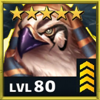

Unrelenting Hunter

**Special Skills**
Deals 250% damage to target and nearby enemies
Reduces max health of the target and nearby enemies by 450 over 3 turns. Max health can’t get lower than 30% of the original health.

**Passives**
Effects on Special Skill - 40% chance to perform the following actions when this character casts their Special Skill
 * Deals 70% damage to all enemies.
 * All enemies get -34% attack for 3 turns.


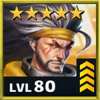

Rod of Freedom

**Special Skills**
Deals 320% damage to the target and minor damage to nearby enemies.
The caster heals 75% of dealt normal damage for 5 turns.
Elemental Link gives all Holy allies +15% attack and +15% defense for 6 turns.  This effect can’t be dispelled.


In [74]:
idx_all = []
idx_all.append(filter_by_1col(df, 'class', 'barba'))
idx_all.append(filter_by_1col(df, 'types', 'hit 3'))
idx_all.append(filter_by_1col(df, 'name', 'us'))
idx_all.append(filter_by_1col(df, 'speed', 'fast', exact_flag=False))

display_heroes_from_df(df[np.all(idx_all,axis=0)])

In [75]:
idx_all = []
idx_all.append(filter_by_1col(df, 'types', 'hit 3'))
idx_all.append(filter_by_1col(df, 'effects', 'dispel'))
# idx_all.append(filter_by_1col(df, 'effects', 'elemental'))
idx_all.append(filter_by_1col(df, 'speed', 'fast', exact_flag=False))

df2 = df[np.all(idx_all,axis=0)]


,name,color,star,class,speed,power,attack,defense,health,types,source,family
280,Evelyn C,green,5,Rogue,Fast,935,899,859,1821,"[Hit 3, Elemental Defense Debuff, Dispeller]",Hotm,2018
856,Musashi C,yellow,5,Barbarian,Fast,928,934,837,1733,"[Hit 3, Self Heal]",Hotm,2017
284,Francine C,green,5,Sorcerer,Fast,812,801,763,1381,"[Hit 3, Cleanser]",Morlovia,Morlovia
106,Iris,blue,5,Wizard,Fast,799,788,751,1378,"[Hit 3, Dispeller]",hotm,2022
67,Alasie C,blue,5,Rogue,Fast,793,752,733,1427,"[Hit 3, Mana reduction]",Hotm,2018
812,Drake Fong C,yellow,5,Fighter,Fast,792,759,727,1416,[Hit 3],Hotm,2018
321,Margaret,green,5,Rogue,Very Fast,770,821,648,1260,"[Hit 3, Dodge Buff]",hotm,2019
279,Evelyn,green,5,Ranger,Fast,768,727,712,1355,"[Hit 3, Elemental Defense Debuff, Dispeller]",Hotm,2018
464,Guardian Panther,purple,5,Fighter,Fast,765,786,630,1349,"[Hit 3, Dispeller, Elemental Defense Debuff]",Teltoc,Guardian
222,Caedmon C2,green,4,Paladin,Fast,734,745,719,1340,"[Hit 3, Dispels Buffs]",Season1,Classic


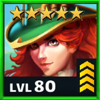

Warcry of the Hunt

**Special Skills**
Deals 200% damage to the target and nearby enemies.
The target and nearby enemies get -56% defense against Nature for 4 turns.
Dispels buffs from target and nearby enemies.
Element Link recovers 4% health for all Nature allies for 6 turns.  This effect can’t be dispelled.


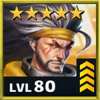

Rod of Freedom

**Special Skills**
Deals 320% damage to the target and minor damage to nearby enemies.
The caster heals 75% of dealt normal damage for 5 turns.
Elemental Link gives all Holy allies +15% attack and +15% defense for 6 turns.  This effect can’t be dispelled.


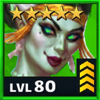

Electric Stab

**Special Skills**
Deals 225% damage to the target and nearby enemies.
Cleanses status ailments from all allies at the end of each turn for 3 turns. This effect can't be dispelled.
All Ice enemies get -54% defense against Nature for 3 turns.


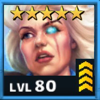

Erase Strength

**Special Skills**
Deals 325% damage to the target and minor damage to the nearby enemies.
Dispells buffs from the target and nearby enemies at the end of each turn  for 3 turns.
Deals extra damage against Fire.
Element Link gives all Ice allies +10% attack for 4 turns. This effect can’t be dispelled.

**Passives**
This character receives 10% mana each time a buff is dispelled from this  character.
This character has innate resistance against Burn.


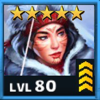

Arrow of Nujalik

**Special Skills**
Deals 386% damage to the target and minor damage to nearby enemies.
Reduces the mana of the target and nearby enemies by 10%.
The target and nearby enemies get -24% mana generation for 3 turns.
Element Link gives all Ice  allies +5% attack and +5% defense for 6 turns. This effect can’t be dispelled.


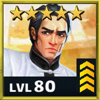

Fabled Fist

**Special Skills**
Deals 240% damage to the target and nearby enemies.
The target and nearby enemies get -50% accuracy for 3 turns. The effect  duration is reset if the target is healed. Chance to miss also applies  to offensive Special Skills. 
Element Link   gives all Holy  allies +5% attack and +5% defense for 6 turns. This effect can’t be dispelled.


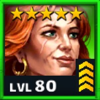

Hide in Shadows

**Special Skills**
Deals 150% damage to the target and nearby enemies
The caster and nearby allies have from +30% to +90% chance of dodging special attacks that do damage. The higher the damage from the special is, the higher the chance to dodge it. Each dodge gives +24% mana to the target.  Effect lasts 3 turns.
Elemental Link gives all Nature allies +46% defense against Fire for 4 turns. This effect cannot be dispelled

**Passives**
This character has an innate ability to resist dispels of buffs.


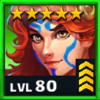

Shattering Warcry

**Special Skills**
Deals 210% damage to the target and nearby enemies
The target and nearby enemies get -54% defense against Nature for 4 turns
Dispels buffs from the target and nearby enemies
Element Link recovers 4% health for all Nature allies for 6 turns. This effect can't be cleansed


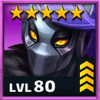

Eye of the Panther

**Special Skills**
Deals 210% damage to the target and nearby enemies
The target and nearby enemies get -54% defense against Dark for 4 turns
Dispels buffs from the target and nearby enemies


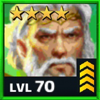

Valorant Strike

**Special Skills**
Deals 275% damage to the target and nearby enemies
The target and nearby enemies are immune to new status effect buffs for 3 turns
Dispels buffs from the target and nearby enemies


In [76]:
display_heroes_from_df(df2.sort_values("power", ascending=False))